In [2]:
import os
import json
import time
import base64
import datetime as dt

import multiprocessing as mp
from functools import partial, lru_cache


import requests
import numpy as np
from osgeo import gdal, ogr

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
ccd_url = r'http://lcmap-test.cr.usgs.gov/ard_cu_c01_v01_aux_cu_v01_ccdc_1_0'
ard_url = r'http://lcmap-test.cr.usgs.gov/ARD_CU_C01_V01'
aux_url = r'http://lcmap-test.cr.usgs.gov/AUX_CU_V01'

def getjson(resource, params=None):
    resp = requests.get(resource, params=params)
    
    if not resp.ok:
        resp.raise_for_status()
        
    return resp.json()

def getsegments(cx, cy, resource=ccd_url):
    """
    CCD results are stored at this level
    """
    resource = f'{resource}/segment'
    params = {'cx': cx, 'cy': cy}
        
    return getjson(resource, params=params)

#def getdates(cx, cy, resource=base_url):
#    """
#    The dates are stored at this level
#    """
#    resource = f'{resource}/chip'
#    params = {'cx': cx, 'cy': cy}
#        
#    return getjson(resource, params=params)
#
#def getmask(cx, cy, resource=base_url):
#    """
#    Processing Mask is stored at this level
#    """
#    resource = f'{resource}/pixel'
#    params = {'cx': cx, 'cy': cy}
#
#    return getjson(resource, params=params)

In [5]:
def getchips(x, y, acquired, ubid, resource=aux_url):
    """
    Make a request to the HTTP API for some chip data.
    """
    chip_url = f'{resource}/chips'
    resp = requests.get(chip_url, params={'x': x,
                                          'y': y,
                                          'acquired': acquired,
                                          'ubid': ubid})
    if not resp.ok:
        resp.raise_for_status()
    
    return resp.json()

@lru_cache()
def getregistry(resource=aux_url):
    """
    Retrieve the spec registry from the API.
    """
    reg_url = f'{resource}/registry'
    return requests.get(reg_url).json()

@lru_cache()
def getspec(ubid):
    """
    Retrieve the appropriate spec information for the corresponding ubid.
    """
    registry = getregistry()
    return next(filter(lambda x: x['ubid'] == ubid, registry), None)

def tonumpy(chip):
    """
    Convert the data response to a numpy array.
    """
    spec = getspec(chip['ubid'])
    data = base64.b64decode(chip['data'])

    chip['data'] = np.frombuffer(data, spec['data_type'].lower()).reshape(*spec['data_shape'])

    return chip

@lru_cache()
def getsnap(x, y, resource=ard_url):
    """
    Get the containing chip and tile coordinate information
    """
    resource = f'{resource}/grid/snap'
    
    return getjson(resource, params={'x': x, 'y': y})

@lru_cache()
def gethv(x, y):
    """
    Get the containing ARD tile h/v
    """
    h, v = getsnap(x, y)['tile']['grid-pt']
    
    return int(h), int(v)

def getnlcd(x, y, resource=aux_url):
    """
    Retrieve the 2001 NLCD layer
    """
    return [tonumpy(c) for c in getchips(x, y, '1999-01-01/2002-01-01', 'AUX_NLCD', resource)][0]

In [6]:
def cuhv_ul(h, v):
    """
    Determine the UL coordinates of an ARD tile in CONUS
    """
    xmin = -2565585 + h * 5000 * 30
    ymax = 3314805 - v * 5000 * 30

    return xmin, ymax

def cutilechips(h, v):
    """
    Build a simple list of all the chips contained in an ARD tile
    """
    ulx, uly = cuhv_ul(h, v)
    # TODO update using grid definitions
    return [(i, j) for i in range(ulx, ulx + 150000, 3000) for j in range(uly, uly - 150000, -3000)]

def buildaffine(ulx, uly, size=30):
    """
    Returns a standard GDAL geotransform affine tuple
    """
    return (ulx, size, 0, uly, 0, -size)

def buildrequestls(trutharr, ulx, uly):
    """
    Build a list of what chips to actually request based on an array of 0 or other.
    Assumes a 30m pixel size and the ulx/uly have already been aligned to the LCMAP chip grid
    """
    aff = buildaffine(ulx, uly, 30)
    rows, cols = trutharr.shape
    truth = trutharr.astype(np.bool)

    return [transform_rowcol(row, col, aff) 
            for row in range(0, rows, 100) 
            for col in range(0, cols, 100)
            if np.any(truth[row:row + 100, col:col + 100])]

In [7]:
def hv_affine(h, v):
    xmin = -2565585 + h * 5000 * 30
    ymax = 3314805 - v * 5000 * 30
    return xmin, 30, 0, ymax, 0, -30

def transform_geo(x, y, affine):
    """
    Transform from a geospatial (x, y) to (row, col).
    """
    col = (x - affine[0]) / affine[1]
    row = (y - affine[3]) / affine[5]
    return int(row), int(col)

def transform_rowcol(row, col, affine):
    """
    Tranform from (row, col) to geospatial (x, y).
    """
    x = affine[0] + col * affine[1]
    y = affine[3] + row * affine[5]
    return x, y

def nlcd(h, v, cpu):
    """
    TODO do this better at some point in the future ...
    """
    arr = np.zeros(shape=(5000, 5000), dtype=np.int)
    affine = hv_affine(h, v)
    chip_ls = cutilechips(h, v)
    
    with mp.Pool(cpu) as pool:
        data = pool.starmap(getnlcd, chip_ls)
    
    for d in data:
        r, c = transform_geo(d['x'], d['y'], affine)
        arr[r:r + 100, c:c + 100] = d['data']

    return arr

def nlcdmask(nlcdarr):
    return nlcdarr > 0

In [8]:
_stability_begining = dt.datetime.strptime('1982-01-01', '%Y-%m-%d')
_isofields = ['sday', 'eday', 'bday']


def seg_position(segment):
    """
    Determine a segment's row/col position within a chip
    """
    row = int((segment['cy'] - segment['py']) / 30)
    col = int((segment['px'] - segment['cx']) / 30)
    return row, col

def strptime(segments):
    """
    Helper function to cast all the ISO-8601 date string fields to Python datetime objects for ease of use
    """
    out = []
    for seg in segments:
        d = {k: (v if k not in _isofields else dt.datetime.strptime(v, '%Y-%m-%d')) for k, v in seg.items()}
        out.append(d)
    return out

def filter_break(segments, date):
    """
    Filter for segments that have actual spectral breaks
    """
    return filter(lambda x: x['chprob'] == 1, segments)

def filter_annual(segments, date):
    """
    Filter for segments that break in within the same year
    """
    return filter(lambda x: x['bday'].year == date.year, segments)

def filter_intersect(segments, date):
    """
    Filter for segments that intersect the date
    """
    return filter(lambda x: x['sday'] <= date <= x['eday'], segments)

def change_doy(segments, date):
    """
    Day of year for any breaks that occurred within same year as the given date
    segments is assumed to be a chip's worth of change detection results
    """
    out = np.zeros(shape=(100, 100), dtype=np.uint16)
    for seg in filter_annual(filter_break(segments, date), date):
        out[seg_position(seg)] = seg['bday'].timetuple().tm_yday
    return out

def change_magnitude(segments, date):
    """
    Magnitude of change for any breaks that occurred within same year as the given date
    segments is assumed to be a chip's worth of change detection results
    """
    out = np.zeros(shape=(100, 100), dtype=np.float)
    for seg in filter_annual(filter_break(segments, date), date):
        out[seg_position(seg)] = np.linalg.norm([seg['grmag'], seg['remag'], seg['nimag'], seg['s1mag'], seg['s2mag']])
    return out

def change_modelqa(segments, date):
    """
    Model curve qa information for any segments that intersect the date
    segments is assumed to be a chip's worth of change detection results
    """
    out = np.zeros(shape=(100, 100), dtype=np.uint8)
    for seg in filter_intersect(segments, date):
        out[seg_position(seg)] = seg['curqa']
    return out

def change_stability(segments, date):
    """
    Length of time that current spectral state has been going on
    segments is assumed to be a chip's worth of change detection results
    """
    init = (date - _stability_begining).days
    out = np.full(shape=(100, 100), fill_value=init, dtype=np.uint32)
    
    for seg in segments:
        if date > seg['eday']:
            diff = (date - seg['eday']).days
        else:
            diff = (date - seg['sday']).days

        if 0 <= diff < out[seg_position(seg)]:
            out[seg_position(seg)] = diff
            
    return out

def change_lastbreak(segments, date):
    """
    Length of time since the last spectral break was detected
    segments is assumed to be a chip's worth of change detection results
    """
    out = np.zeros(shape=(100, 100), dtype=np.uint32)
    for seg in filter_break(segments, date):
        diff = (date - seg['bday']).days
        if diff > 0:
            val = out[seg_position(seg)]
            if diff < val or val == 0:
                out[seg_position(seg)] = diff
    return out



#############################################
# Synthetic Section
#############################################

_coefs = ['blcoef', 'grcoef', 'recoef', 'nicoef', 's1coef', 's2coef', 'thcoef']
_intrs = ['blint', 'grint', 'reint', 'niint', 's1int', 's2int', 'thint']

def predict(coefficients, intercept, date):
    ordinal = date.toordinal()
    w = 2 * np.pi / 365.2425
    if not coefficients:
        return 0
    else:
        sl, c1, c2, c3, c4, c5, c6 = coefficients
        return (c1 * np.cos(w * ordinal) + c2 * np.sin(w * ordinal) +
                c3 * np.cos(2 * w * ordinal) + c4 * np.sin(2 * w * ordinal) +
                c5 * np.cos(3 * w * ordinal) + c6 * np.sin(3 * w * ordinal) +
                intercept + sl * ordinal)

def predict_band(segment, date, band):
    coefs = f'{band}coef'
    inter = f'{band}int'
    return predict(segment[coefs], segment[inter], band)

def predict_all(segment, date):
    if segment['curqa'] == 44 or segment['curqa'] == 54:
        return [predict(segment[c], segment[i], date) for c, i in zip(_coefs, _intrs)]
    else:
        # Need to adjust Celsius back to Kelvin
        preds = [predict(segment[c], segment[i], date) for c, i in zip(_coefs[:-1], _intrs[:-1])]
        preds.append(tokelvin(predict(segment[_coefs[-1]], segment[_intrs[-1]], date)))
        return preds

def filter_intersect_syn(segments, date):
    """
    Filter for segments that intersect the date
    """
    return filter(lambda x: x['sday'] <= date < x['bday'], segments)


def groupsegs(segments, date, mask):
    """
    Group segments based on (px, py) and then sort them based on sday.
    """ 
    out = {}
    for seg in filter(lambda x: mask[seg_position(x)] != 1, segments):
        loc = (seg['px'], seg['py'])
    
        if loc not in out:
            out[loc] = []
        
        out[loc].append(seg)
    
    return {k: sorted(v, key=lambda x: x['sday']) for k, v in out.items()}


def syntheticselect(segments, date):
    """
    Segments need to be sorted based on the sday.
    """
    if not segments:
        return None

    # ord date before time series models -> cover back
    if date < segments[0]['sday']:
        return segments[0]

    # ord date after time series models -> cover forward
    if date > segments[-1]['eday']:
        return segments[-1]

    prev_br = 0
    for m in segments:
        # Date is contained within the model
        if m['sday'] <= date <= m['eday']:
            return m
        elif prev_br != 0 and prev_br <= date < m['sday']:
            return m
        elif m['eday'] < date < m['bday']:
            return m

        prev_br = m['bday']

    raise ValueError

def tokelvin(therm):
    return therm / 10 + 27315

def synthetic(segments, date):
    
    mask_array = np.zeros(shape=(100, 100), dtype=np.int8) #marks which pixels are completed
    out = np.zeros(shape=(100, 100, 7), dtype=np.int16)
    
    for seg in filter_intersect_syn(segments, date): # get intersecting segments by date and compute model
        out[seg_position(seg)] = predict_all(seg, date)
        mask_array[seg_position(seg)] = 1
        
    segments = groupsegs(segments, date, mask_array)  #using the remaining segments, group and sort for model testing
    
    for locs in segments.values():
        seg = syntheticselect(locs, date)
        out[seg_position(seg), :] = predict_all(seg, date)
    
    
    return out

#########################
#End Synthetic Section
##################################

prod_map = {'doy': change_doy,
            'magnitude': change_magnitude,
            'modelqa': change_modelqa,
            'stability': change_stability,
            'lastbreak': change_lastbreak,
            'synthetic': synthetic}

def process(cx, cy, prodfunc, date):
    data = strptime(getsegments(cx, cy))
    return cx, cy, prodfunc(data, date)

def buildproduct(h, v, product, date, cpu):
    func = partial(process, prodfunc=prod_map[product], date=date)
    affine = hv_affine(h, v)
    mask = nlcdmask(nlcd(h, v, cpu))
    chip_ls = buildrequestls(mask, affine[0], affine[3])
    
    if product == 'synthetic':
        out = np.zeros(shape=(5000, 5000, 7))
    else:
        out = np.zeros(shape=(5000, 5000))
        
    with mp.Pool(cpu) as pool:
        data = pool.starmap(func, chip_ls)
        
    for d in data:
        r, c = transform_geo(d[0], d[1], affine)
        out[r:r + 100, c:c + 100] = d[2]
        
    out[~mask.astype(np.bool)] = 0
        
    return out



In [9]:
dates = [
    '2016-02-01',
    '2016-02-15',
    '2016-03-15',
    '2016-03-31',
    '2016-05-29',
    '2016-07-19',
    '2016-10-01',
    
]


tiles = [
    
    #(19,10),
    #(19,11),
    #(19,12),
    #(19,13),
    #(19,14),
    #(19,15),
    #(19,16),
    #(19,17),
    #(20,10),
    #(20,11),
    #(20,12),
    #(20,13),
    #(20,14),
    #(20,15),
    #(20,16),
    #(20,17),
    #(21,10),
    #(21,11),
    #(21,12),
    #(21,13),
    #(21,14),
    #(21,15),
    #(21,16),
    #(21,17),
    #(22,10),
    #(22,11),
    #(22,12),
    #(22,13),
    #(22,14),
    #(22,15),
    #(22,16),
    #(23,7),
    #(23,8),
    #(23,9),
    (23,10),
    (23,11),
    (23,12),
    #(23,13),
    #(23,14),
    #(23,15),
    #(23,16),
    #(24,6),
    #(24,7),
    #(24,8),
    #(24,9),
    #(24,10),
    #(24,11),
    #(24,12),
    #(24,13),
    #(24,14),
    #(24,15),
    #(24,16),
    #(25,11),
    #(25,12),
    #(25,13),
    #(25,14),
    #(25,15),
    #(25,16),
    #(25,17),
    #(25,18),
    #(26,11),
    #(26,12),
    #(26,13),
    #(26,14),
    #(26,15),
    #(26,16),
    #(26,17),
    #(26,18),
    #(26,19),
    #(27,11),
    #(27,12),
    #(27,13),
    #(27,14),
    #(27,17),
    #(27,18),
    #(27,19),
    #(27,20),
    #(28,7),
    #(28,8),
    #(28,9),
    #(28,10),
    #(28,11),
    #(28,12),
    #(28,13),
    #(29,7),
    #(29,8),
    #(29,9),
    #(29,11),
    #(29,12),
    #(30,7)    
]


In [10]:
def getgrids(resource=ard_url):
    """
    Retrieve the tile and chip definitions for the grid (geospatial transformation information)
    from the API.
    """
    grid_url = f'{resource}/grid'
    return requests.get(grid_url).json()

def getgrid(grid, resource=ard_url):
    """
    Pull specific grid definition from the list of grids.
    """
    grids = getgrids(resource)
    return next(filter(lambda x: x['name'] == grid, grids), None)

for d in dates:
    for t in tiles:
        outfile = r'/data/Landfire/h{}v{}_Synthetic_{}.tif'.format(t[0],t[1],d)       
        t1 = time.time() 
        print("starting ", outfile)
        exists = os.path.isfile(outfile)
        if exists: 
            print("already exists ", outfile)
            #do nothing if file already exists
        else:
            mydata = buildproduct(t[0], t[1], 'synthetic', dt.datetime.strptime(d, '%Y-%m-%d'), 12)     
            
            y_res, x_res = mydata.shape[0:2]
            outds = gdal.GetDriverByName('GTiff').Create(outfile, x_res, y_res, 7, gdal.GDT_Int16)
            outds.SetGeoTransform(hv_affine(t[0], t[1]))
            outds.SetProjection(getgrid('chip')['proj'])
            outds.GetRasterBand(1).WriteArray(mydata[:,:,0])
            outds.GetRasterBand(2).WriteArray(mydata[:,:,1])
            outds.GetRasterBand(3).WriteArray(mydata[:,:,2])
            outds.GetRasterBand(4).WriteArray(mydata[:,:,3])
            outds.GetRasterBand(5).WriteArray(mydata[:,:,4])
            outds.GetRasterBand(6).WriteArray(mydata[:,:,5])
            outds.GetRasterBand(7).WriteArray(mydata[:,:,6])
            outds = None
            mydata = None
            print("finished ", outfile, time.time()-t1)

starting  /data/Landfire/h23v10_Synthetic_2016-02-01.tif
finished  /data/Landfire/h23v10_Synthetic_2016-02-01.tif 1040.2782554626465
starting  /data/Landfire/h23v11_Synthetic_2016-02-01.tif
finished  /data/Landfire/h23v11_Synthetic_2016-02-01.tif 920.3335320949554
starting  /data/Landfire/h23v12_Synthetic_2016-02-01.tif
finished  /data/Landfire/h23v12_Synthetic_2016-02-01.tif 1011.9116539955139
starting  /data/Landfire/h23v10_Synthetic_2016-02-15.tif
finished  /data/Landfire/h23v10_Synthetic_2016-02-15.tif 995.5695986747742
starting  /data/Landfire/h23v11_Synthetic_2016-02-15.tif
finished  /data/Landfire/h23v11_Synthetic_2016-02-15.tif 904.5237531661987
starting  /data/Landfire/h23v12_Synthetic_2016-02-15.tif
finished  /data/Landfire/h23v12_Synthetic_2016-02-15.tif 1014.8692076206207
starting  /data/Landfire/h23v10_Synthetic_2016-03-15.tif
finished  /data/Landfire/h23v10_Synthetic_2016-03-15.tif 975.5801606178284
starting  /data/Landfire/h23v11_Synthetic_2016-03-15.tif
finished  /data/

In [16]:
t1 = time.time()
synthetic1996 = buildproduct(28, 6, 'synthetic', dt.datetime.strptime('1996-01-01', '%Y-%m-%d'), 20)
print(time.time()-t1)

Process ForkPoolWorker-62:
Process ForkPoolWorker-64:
Process ForkPoolWorker-63:
Process ForkPoolWorker-53:
Process ForkPoolWorker-57:
Process ForkPoolWorker-58:
Process ForkPoolWorker-56:
Process ForkPoolWorker-54:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:
Process ForkPoolWorker-61:
Process ForkPoolWorker-50:
Process ForkPoolWorker-49:
Process ForkPoolWorker-47:
Process ForkPoolWorker-48:
Process ForkPoolWorker-60:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Process ForkPoolWorker-55:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [69]:
t1 = time.time()
stab1996 = buildproduct(31, 2, 'stability', dt.datetime.strptime('1996-07-01', '%Y-%m-%d'), 12)
print(time.time() - t1)

Process ForkPoolWorker-743:
Process ForkPoolWorker-744:
Process ForkPoolWorker-742:
Process ForkPoolWorker-741:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
 

KeyboardInterrupt: 

  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py",

In [ ]:
break2001 = buildproduct(31, 3, 'lastbreak', dt.datetime.strptime('2001-07-01', '%Y-%m-%d'), 20)

Text(0.5, 1.0, 'Spectral Stability 1996')

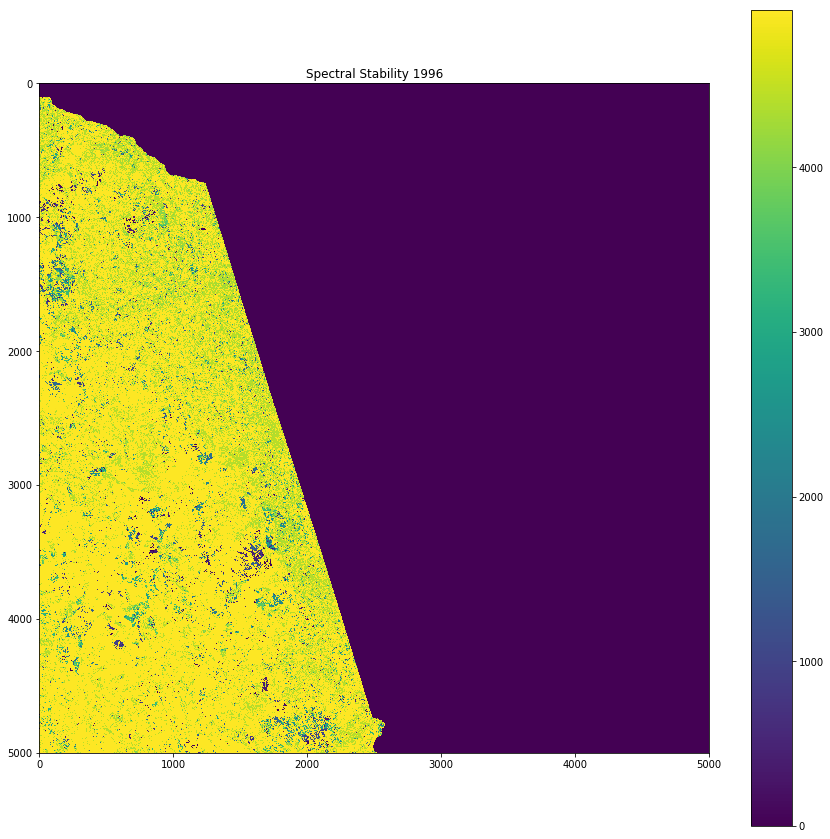

In [53]:
plt.figure(figsize=(15, 15))
plt.imshow(stab1996)
plt.colorbar()
plt.title('Spectral Stability 1996')

In [66]:
def getgrids(resource=ard_url):
    """
    Retrieve the tile and chip definitions for the grid (geospatial transformation information)
    from the API.
    """
    grid_url = f'{resource}/grid'
    return requests.get(grid_url).json()

def getgrid(grid, resource=ard_url):
    """
    Pull specific grid definition from the list of grids.
    """
    grids = getgrids(resource)
    return next(filter(lambda x: x['name'] == grid, grids), None)

y_res, x_res = break2001.shape
outds = gdal.GetDriverByName('GTiff').Create('h31v03_break_2001.tif', x_res, y_res, 1, gdal.GDT_Int16)
outds.SetGeoTransform(hv_affine(31, 3))
outds.SetProjection(getgrid('chip')['proj'])
outds.GetRasterBand(1).WriteArray(break2001)
outds = None